In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from IPython.display import display
plt.style.use(["/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle"])
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

# Load Previous Selection Tag

In [2]:
from LoadMultiFiles import LoadOneFileUproot
from ConcanatePreviousPrediction import GetSelectedDataframe
fileID = 0
path_evtTruth=f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/tag_event/root/sn_tag_{fileID}.root"
path_AP=f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/AfterPulsePrediction/root/TagAfterPulse_{fileID}.root"
path_PSD=f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/PSD/root/user_PSD_{fileID}_SN.root"
path_IBD=f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/PromptDelayedSignalSelection/root_PromptDelayedSelection/IBD_{fileID}_optimized.root"
path_CC=f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/PromptDelayedSignalSelection/root_PromptDelayedSelection/CC_{fileID}_optimized.root"

df_map = GetSelectedDataframe(path_evtTruth=path_evtTruth,
                              path_IBD=path_IBD,
                              path_AP=path_AP,
                              path_PSD=path_PSD,
                              path_CC=path_CC,
                              inf_from_evtType=["evtType", "R", "recE"])
display(df_map)

,evtType,R,recE,TagAP,TagIBDp,TagIBDd,IBDSource,psdVal,TagPSD,TagCCp,TagCCd,CCSource
0,pES,6854.586489,0.195969,0,0,0,-1,4.332481e-03,2,0,0,0
1,N12,15130.035355,58.678581,0,0,0,-1,9.998755e-01,1,1,0,-1
2,AfterPulse,586.030974,0.444959,1,0,0,0,5.603862e-03,2,0,0,0
3,AfterPulse,540.508380,0.287102,1,0,0,0,7.416920e-07,2,0,0,0
4,IBDp,12277.913790,12.297911,0,1,0,-1,9.968648e-01,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18663,pES,14187.729726,0.173486,0,0,0,-1,1.275571e-03,2,0,0,0
18664,IBDp,11950.287108,12.726572,0,1,0,-1,9.985903e-01,1,0,0,0
18665,IBDd,12043.002196,2.300554,0,0,1,18664,9.971751e-01,1,0,0,0
18666,IBDp,15591.648029,17.081907,0,1,0,-1,9.998966e-01,1,0,0,0


### Check Energy Scale

0.9999999776918292


Text(0.5, 1.0, 'IBD Delay Signal')

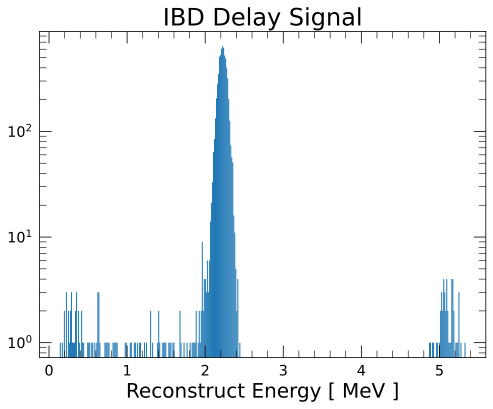

In [3]:
R_FV_cut = 17
from HistTools import GetBinCenter
h = plt.hist(df_map[df_map["evtType"]=="IBDd"]["recE"],bins=400)
plt.xlabel("Reconstruct Energy [ MeV ]")
bins_center = GetBinCenter(h[1])
plt.semilogy()
print(2.223/bins_center[np.argmax(h[0])])
plt.title("IBD Delay Signal")

# Load Isolation Cut Tag

In [4]:
dir_root_path = "/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/PromptDelayedSignalSelection/OptimizeIsolationCut/root/"
import glob
v_files = glob.glob(dir_root_path+"*.root")

import re
m = re.compile( dir_root_path+"Isolation_0_IsolationCriteria_(.*)m_(.*)ms.root", re.IGNORECASE)

# Previous Cut
FV_cut = 17e3 # mm
index_residue = ( (df_map["TagAP"]==0) & (df_map["TagPSD"]==1) & (df_map["TagIBDp"]==0) &
                  (df_map["TagIBDd"]==0) & (df_map["TagCCp"]==0) & (df_map["TagCCd"]==0) &
                  (df_map["R"]<FV_cut))

dir_eff = {"dR_cut":[], "dt_cut":[], "Signal Eff.":[], "Background Ineff.":[],
           "Contamination":[], "Purity":[], "Significance":[], "N of Signal":[],
           "N of Background":[]}
v_evtType_as_signal = ["eES","C12"]

for i, file in enumerate( v_files ):
    pair_config = m.match(file).groups()
    dir_eff["dR_cut"].append(float(pair_config[0]))
    dir_eff["dt_cut"].append( round( float(pair_config[1]),1) )

    dir_IsolationTag = LoadOneFileUproot( file, name_branch="SingleSelection", return_list=False )
    df_IsolationTag = pd.DataFrame.from_dict(dir_IsolationTag)
    df_map["TagSingle"] = df_IsolationTag["TagSingle"]

    # Residual eES and CC
    # df_residue = df_map[ (index_residue) & (df_map["evtType"]!="C12") ]
    df_residue = df_map[ (index_residue) ]

    # Get Signal Efficiency and Background Inefficiency
    ## Residue Count After Isolation Cut
    df_residue_count = df_residue.groupby( ["TagSingle", "evtType"] ).size()
    n_signal_residue = np.sum( df_residue_count.xs(1,level="TagSingle").loc[v_evtType_as_signal] )
    n_residue = np.sum( df_residue_count.xs(1,level="TagSingle") )
    n_background_residue = n_residue - n_signal_residue

    ## Whole Sample Count
    df_whole_sample_count = df_residue.groupby( "evtType" ).size()
    n_total_signal = np.sum( df_whole_sample_count[v_evtType_as_signal] )
    n_total_background = len(df_residue) - n_total_signal

    ## Efficiency
    dir_eff["Signal Eff."].append( n_signal_residue/n_total_signal *100 )
    dir_eff["Background Ineff."].append( n_background_residue/n_total_background * 100 )
    dir_eff["Contamination"].append( n_background_residue/(n_signal_residue+n_background_residue) *100 )
    dir_eff["Purity"].append( n_signal_residue/(n_signal_residue+n_background_residue) *100 )
    dir_eff["Significance"].append( n_signal_residue / np.sqrt( n_signal_residue+n_background_residue ) )
    dir_eff["N of Signal"].append( n_signal_residue)
    dir_eff["N of Background"].append( n_background_residue )

    if i==0:
        display( df_residue.groupby(["TagSingle", "evtType"]).size() )

df_eff = pd.DataFrame.from_dict( dir_eff )
display( df_eff )



TagSingle  evtType   
0          B12             2
           C12            43
           IBD             4
           IBDd          110
           IBDp           68
           N12            10
           eES            23
           pES             1
           pileUp         10
1          AfterPulse      2
           B12            11
           C12           203
           IBD            16
           IBDd           30
           IBDp          100
           N12            14
           eES           210
           pES             7
           pileUp         16
dtype: int64

,dR_cut,dt_cut,Signal Eff.,Background Ineff.,Contamination,Purity,Significance,N of Signal,N of Background
0,5.0,3.0,86.221294,48.877805,32.183908,67.816092,16.735605,413,196
1,3.0,8.0,91.440501,54.114713,33.129771,66.870229,17.114076,438,217
2,5.0,4.0,82.045929,44.389027,31.173380,68.826620,16.446538,393,178
3,1.0,0.6,100.000000,80.299252,40.199750,59.800250,16.924633,479,322
4,4.0,1.0,95.407098,62.344140,35.360679,64.639321,17.187254,457,250
...,...,...,...,...,...,...,...,...,...
76,6.0,16.0,53.444676,14.463840,18.471338,81.528662,14.446916,256,58
77,7.0,8.0,59.081420,20.448878,22.465753,77.534247,14.812897,283,82
78,8.0,8.0,51.356994,14.214464,18.811881,81.188119,14.132331,246,57
79,2.0,1.0,99.164927,72.319202,37.908497,62.091503,17.173661,475,290


['Signal Eff.', 'Background Ineff.', 'Contamination', 'Purity', 'Significance', 'N of Signal', 'N of Background']


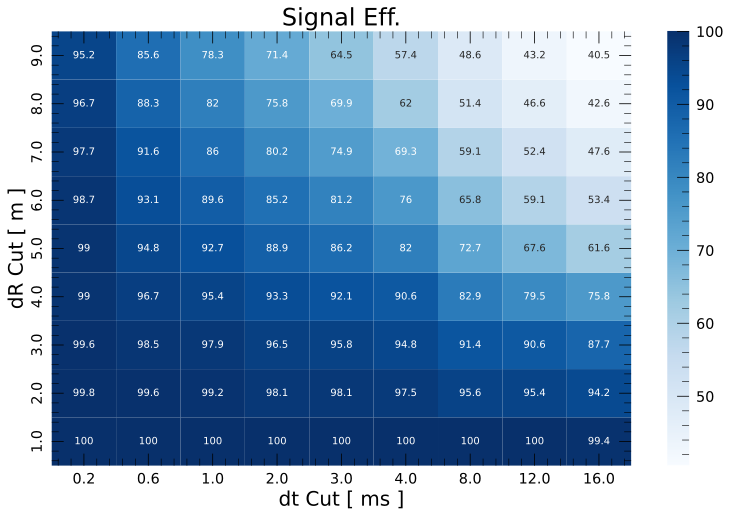

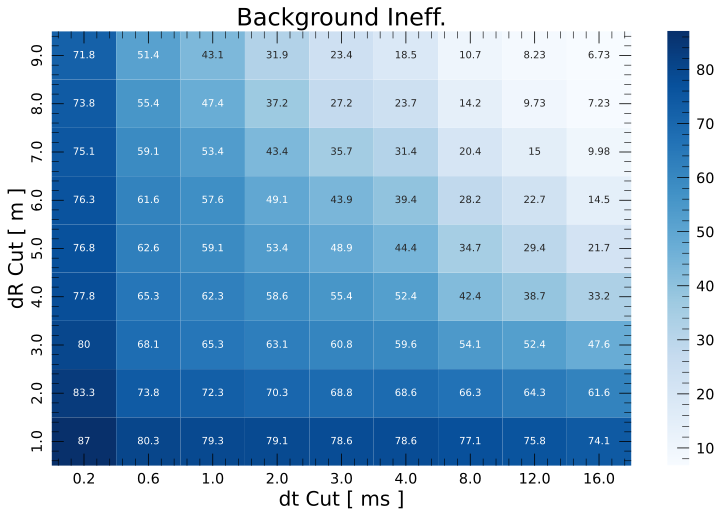

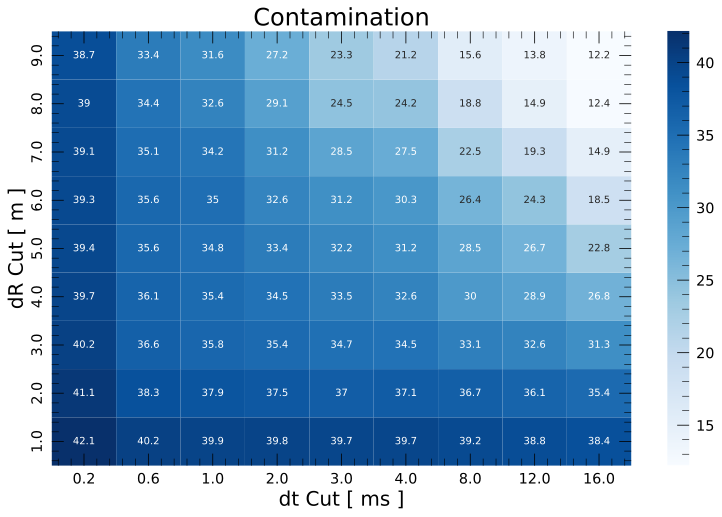

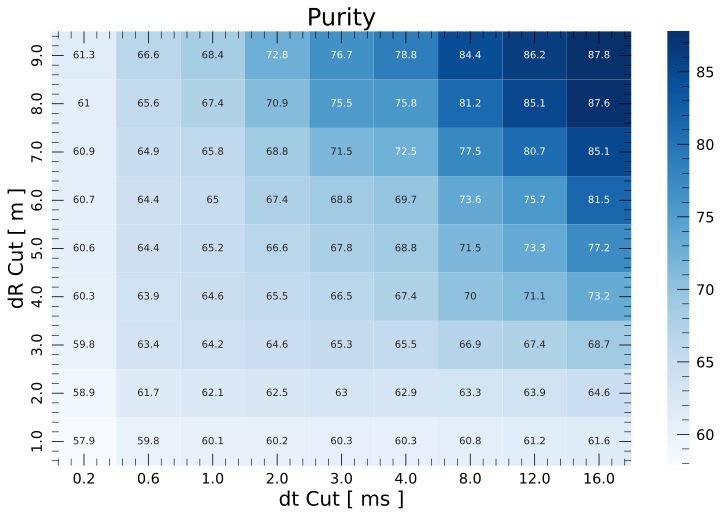

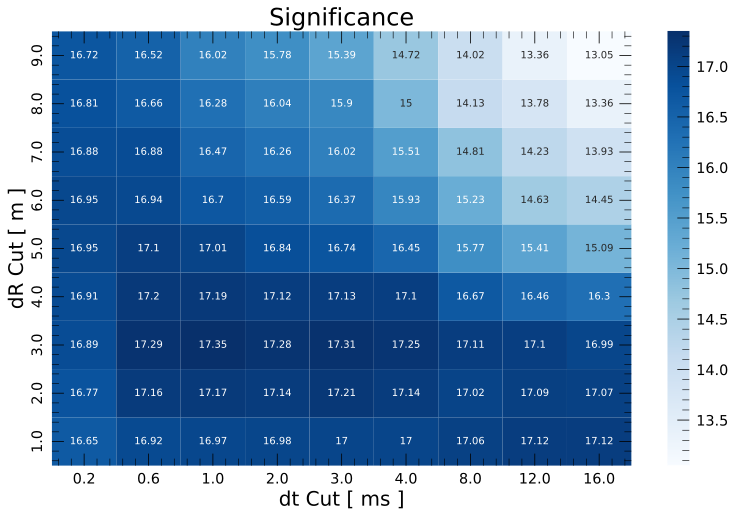

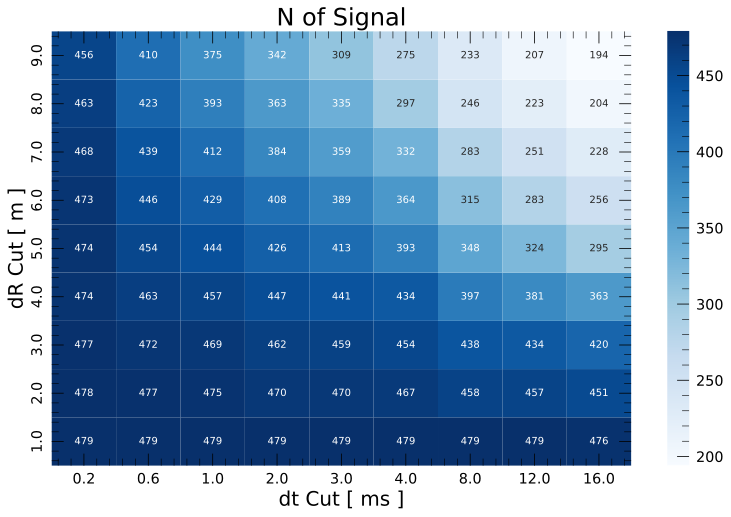

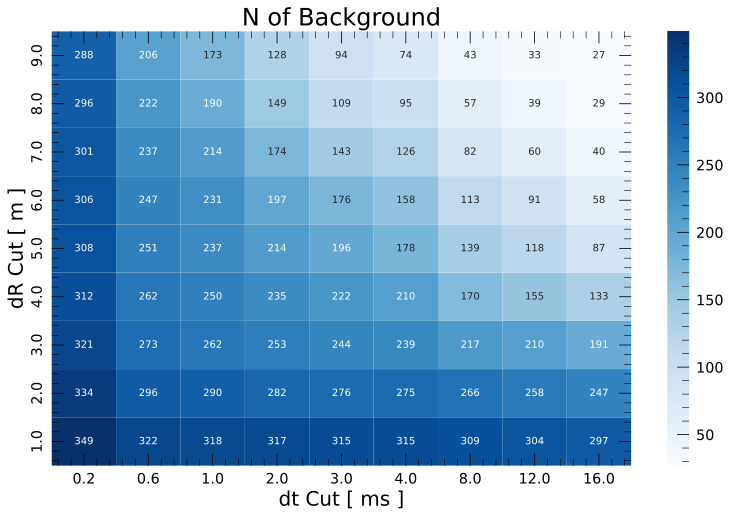

In [5]:
import seaborn as sns
v_not_plot = ["dt_cut", "dR_cut"]
v_keys_to_plot = [key for key in list( dir_eff.keys() ) if key not in v_not_plot]
print(v_keys_to_plot)
for key in v_keys_to_plot:
    plt.figure(figsize=(13,8))
    df_heatmap = df_eff.pivot_table(index="dR_cut",columns="dt_cut", values=key)
    ax = sns.heatmap( df_heatmap, cmap="Blues", annot=True, fmt=".4g" if key == "Significance" else ".3g")
    plt.title(key)
    ax.invert_yaxis()
    plt.xlabel("dt Cut [ ms ]")
    plt.ylabel("dR Cut [ m ]")

# Optimized Isolation Cut
## 1. Energy Spectrum

In [6]:
name_criteria = "Significance"
dir_IsolationTag = LoadOneFileUproot( v_files[ df_eff[name_criteria].argmax() ], name_branch="SingleSelection", return_list=False )
print(v_files[ df_eff[name_criteria].argmax() ])
df_IsolationTag = pd.DataFrame.from_dict(dir_IsolationTag)
df_map["TagSingle"] = df_IsolationTag["TagSingle"]
df_residue = df_map[ index_residue ]

/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/PromptDelayedSignalSelection/OptimizeIsolationCut/root/Isolation_0_IsolationCriteria_3m_1.0ms.root


In [7]:
df_table = df_residue.groupby(["TagSingle", "evtType"]).size()
pd.concat((df_table.xs(0, level="TagSingle"), df_table.xs(1, level="TagSingle")),axis=1).fillna(0)

# df_residue.groupby([ "evtType"]).size()


,0,1
evtType,,
C12,4.0,242
IBD,2.0,18
IBDd,96.0,44
IBDp,34.0,134
N12,2.0,22
eES,6.0,227
pileUp,5.0,21
AfterPulse,0.0,2
B12,0.0,13


## 1. Comparison with Truth Spectrum

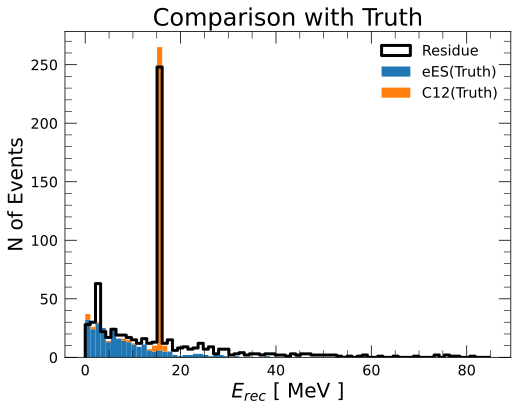

In [8]:
from importlib import reload
import PlotSpectrum
reload(PlotSpectrum)
from PlotSpectrum import PlotSpectrumComponents, CompareWithTruthSpectrum
CompareWithTruthSpectrum(df_residue[df_residue["TagSingle"]==1], df_map, v_truth_to_plot=v_evtType_as_signal,
                         logy=False)

In [9]:
df_residue[df_residue["TagSingle"]==1].groupby([ "evtType"]).size()

evtType
AfterPulse      2
B12            13
C12           242
IBD            18
IBDd           44
IBDp          134
N12            22
eES           227
pES             8
pileUp         21
dtype: int64

## 2. Components of Residual Spectrum

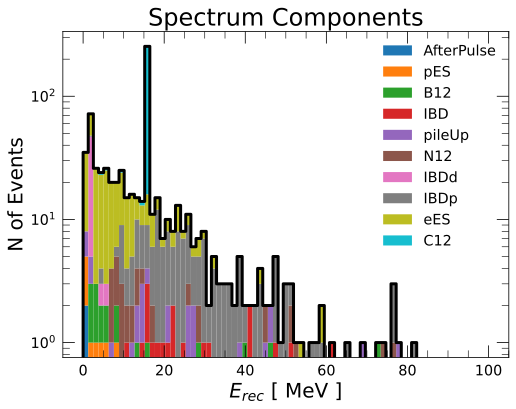

In [10]:
PlotSpectrumComponents(df_residue[df_residue["TagSingle"]==1],logy=True)

Text(0.5, 0, 'Reconstruct Energy [ MeV ]')

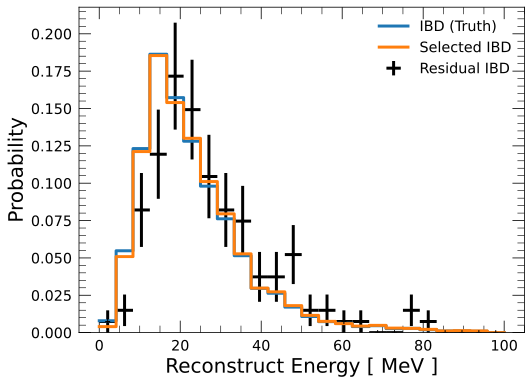

In [11]:
import PlotErrorBar
reload(PlotErrorBar)
from PlotErrorBar import PLotDataWithErrorBar_numpy
bins_Erec = np.linspace(0, 100,25)

h = np.histogram( df_residue[ (df_residue["TagSingle"]==1) &
                              ( (df_residue["evtType"]=="IBDp") )]["recE"], bins=bins_Erec)
PLotDataWithErrorBar_numpy(h[0], h[1], density=True, color="black", label="Residual IBD" )

sns.histplot( df_map[ (df_map["evtType"]=="IBDp") ]["recE"], bins=bins_Erec, stat="probability", fill=False,
              element="step", label="IBD (Truth)")
sns.histplot( df_map[ df_map["TagIBDp"]==1]["recE"], bins=bins_Erec,
              stat="probability", fill=False,element="step", label="Selected IBD")

plt.legend()
plt.xlabel("Reconstruct Energy [ MeV ]")

In [12]:
v_PSD_Tags = [2, 1, 1]
df_map_within_FV = df_map[df_map["R"]<R_FV_cut*1e3]
v_Title = ["pES", "eES+NC","CC"]
index_notIBD = ( (df_map_within_FV["TagAP"]==0) & (df_map_within_FV["TagIBDp"]==0) & (df_map_within_FV["TagIBDd"]==0) )
v_index = [index_notIBD, index_notIBD&(df_map_within_FV["TagCCp"]==0)&(df_map_within_FV["TagCCd"]==0)&(df_map_within_FV["TagSingle"]==1),
           index_notIBD&(df_map_within_FV["TagCCp"]==1)&(df_map_within_FV["TagCCd"]==0)]
# v_index = [index_notIBD, index_notIBD&(df_map_within_FV["TagCCp"]==0)&(df_map_within_FV["TagCCd"]==0),
#            index_notIBD&(df_map_within_FV["TagCCp"]==1)&(df_map_within_FV["TagCCd"]==0)]
df_residue_components = pd.DataFrame()
for PSD_tag, title,index in zip( v_PSD_Tags, v_Title,v_index ):
    df_temp = df_map_within_FV[ index & (df_map_within_FV["TagPSD"]==PSD_tag) ].groupby("evtType").size().reset_index(name=title).set_index("evtType")
    df_temp[title] = df_temp[title]/ np.sum( df_temp[title] )
    df_residue_components = pd.concat( [df_residue_components,df_temp], axis=1)

# IBD Selection
index_IBD_event = ((df_map_within_FV["TagAP"]==0) &
                   ( (df_map_within_FV["TagIBDp"]==1) & (df_map_within_FV["TagIBDd"]==0) )  )
title="IBD"
df_temp = df_map_within_FV[ index_IBD_event ].groupby("evtType").size().reset_index(name=title).set_index("evtType")
df_temp[title] = df_temp[title]/ np.sum( df_temp[title] )
df_residue_components = pd.concat( [df_residue_components,df_temp], axis=1)

df_residue_components =  df_residue_components.fillna(0)
pd.options.display.float_format = '{:,.2f}'.format
df_residue_components*100

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


,pES,eES+NC,CC,IBD
evtType,,,,
AfterPulse,0.18,0.27,0.00,0.00
C12,0.12,33.11,0.58,0.03
IBD,0.24,2.46,0.00,0.05
IBDd,1.07,6.02,0.00,0.03
IBDp,1.07,18.33,2.31,97.77
eES,0.48,31.05,0.00,0.02
pES,94.69,1.09,0.00,0.07
pileUp,2.15,2.87,1.73,1.97
B12,0.00,1.78,39.31,0.05


In [13]:
df_map_within_FV

,evtType,R,recE,TagAP,TagIBDp,TagIBDd,IBDSource,psdVal,TagPSD,TagCCp,TagCCd,CCSource,TagSingle
0,pES,"6,854.59",0.20,0,0,0,-1,0.00,2,0,0,0,0
1,N12,"15,130.04",58.68,0,0,0,-1,1.00,1,1,0,-1,0
2,AfterPulse,586.03,0.44,1,0,0,0,0.01,2,0,0,0,0
3,AfterPulse,540.51,0.29,1,0,0,0,0.00,2,0,0,0,0
4,IBDp,"12,277.91",12.30,0,1,0,-1,1.00,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18663,pES,"14,187.73",0.17,0,0,0,-1,0.00,2,0,0,0,0
18664,IBDp,"11,950.29",12.73,0,1,0,-1,1.00,1,0,0,0,0
18665,IBDd,"12,043.00",2.30,0,0,1,18664,1.00,1,0,0,0,0
18666,IBDp,"15,591.65",17.08,0,1,0,-1,1.00,1,0,0,0,0
